In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from spikingjelly0.spikingjelly.activation_based import neuron, functional, layer

## Some simple neuron testing
primarily showing how inference (input/output mechanics of neuron) works, e.g., is connectivity one-to-one or recurrent (convolutional, fully connected, etc.)

using a LIF neuron in this case

In [42]:
# neuron
lif = neuron.LIFNode(tau=10.)
# timesteps
T = 100

# testing nothing
zero= torch.zeros(5, 5)
print(f'neuron voltage before nothing: {lif.v}')
lif(zero)
print(f'neuron voltage after nothing:\n{lif.v}')

print()

#testing neuron activation given single stimulus
lif.reset()
one = torch.zeros(5, 5)
one[2, 2] = 1
print(f'input with only one one:\n{one}')
print(f'neuron voltage before one: {lif.v}')
lif(one)
print(f'neuron voltage after one:\n{lif.v}')

print()

# resest test
lif.reset()
print(f'neuron voltage after being reset:\n{lif.v}')


neuron voltage before nothing: 0.0
neuron voltage after nothing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

input with only one one:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
neuron voltage before one: 0.0
neuron voltage after one:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

neuron voltage after being reset:
0.0


In [43]:
# testing more stimuli
lif.reset()
nine = torch.zeros(5, 5)
nine[1:4, 1:4] = 1
print(f'input with only nine ones:\n{nine}')
print(f'neuron voltage before one: {lif.v}')
lif(nine)
print(f'neuron voltage after one:\n{lif.v}')

input with only nine ones:
tensor([[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]])
neuron voltage before one: 0.0
neuron voltage after one:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.1000, 0.1000, 0.0000],
        [0.0000, 0.1000, 0.1000, 0.1000, 0.0000],
        [0.0000, 0.1000, 0.1000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


note: seems that there is no recurrent behavior by default
will try adding recurrent behavior and see what happens

## A quick guide to using spikingjelly.visualizing

In [54]:
from spikingjelly import visualizing
import math

In [68]:
stimulus = nine[:, 2].unsqueeze(0)
print(stimulus)
stimulus2 = torch.zeros(stimulus.shape)
stimulus2[0, 2] = 1
print(stimulus2)
zero_stimulus = zero[:, 2].unsqueeze(0)
print(zero_stimulus)

tensor([[0., 1., 1., 1., 0.]])
tensor([[0., 0., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0.]])


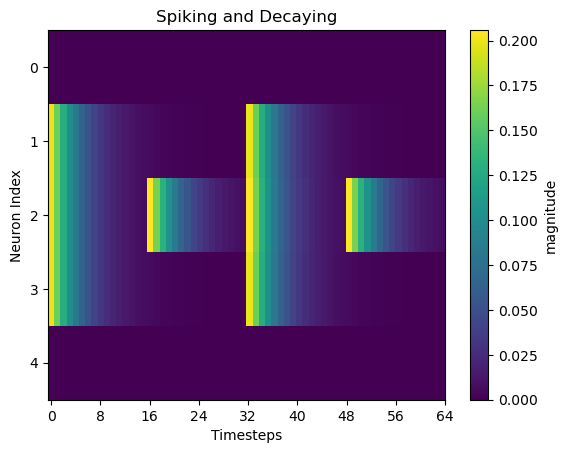

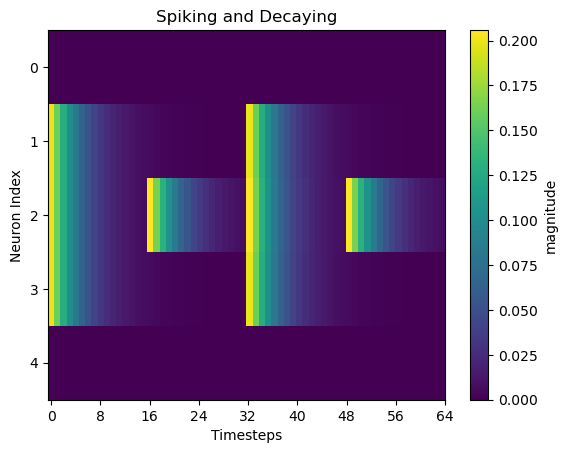

In [73]:
lif = neuron.LIFNode(tau=5.)
lif.reset()
T = 64
voltages = []
for t in range(T):
  if t % math.floor(T/2) == 0:
    lif(stimulus)
  elif t % math.floor(T/4) == 0:
    lif(stimulus2)
  else:
    lif(zero_stimulus)
  voltages.append(lif.v)

voltages = torch.cat(voltages, dim=0)

visualizing.plot_2d_heatmap(array=voltages, title='Spiking and Decaying', xlabel='Timesteps', ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=100)

In [31]:
transform = transforms.Compose([
  transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [32]:
print(len(mnist_trainset))
print(len(mnist_testset))
print(type(mnist_trainset))

im = mnist_trainset[0][0]
print(type(im))

60000
10000
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torch.Tensor'>


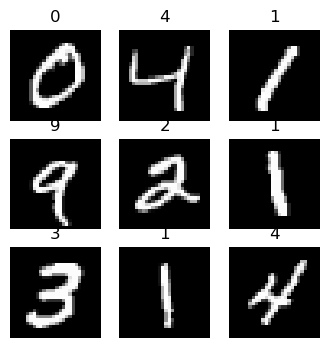

In [33]:
# show some of the numbers/photos
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, num = mnist_trainset[i]
    figure.add_subplot(rows, cols, i)
    plt.title(num)
    plt.axis("off")
    plt.imshow(transforms.ToPILImage(mode="L")(img), cmap="gray")
plt.show()

In [34]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1, shuffle=True)

In [35]:
# define network architecture
net = nn.Sequential(
  # layer.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2), # (28, 28)
  # layer.BatchNorm2d(num_features=1), # (28, 28)
  neuron.IFNode(step_mode='s'), # (28, 28)
  # layer.MaxPool2d(kernel_size=2, stride=2), # (14, 14)
  layer.Flatten(), # (14*14,)
  layer.Linear(in_features=28*28, out_features=10), # (10,)
  nn.Softmax(),
  # neuron.LIFNode(step_mode='s') # (10,)
)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

5
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
tensor(784)
torch.Size([1, 28, 28])
tensor([[0.1032, 0.0965, 0.0966, 0.1011, 0.1000, 0.1034, 0.1004, 0.1061, 0.0972,
         0.0955]], grad_fn=<SoftmaxBackward0>)
0
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor(784)
torch.Size([1, 28, 28])
tensor([[0.0796, 0.0936, 0.1203, 0.0866, 0.1018, 0.1071, 0.0622, 0.1195, 0.1133,
         0.1159]], grad_fn=<SoftmaxBackward0>)
4
tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])
tensor(784)
torch.Size([1, 28, 28])
tensor([[0.1069, 0.0997, 0.0863, 0.0927, 0.1086, 0.1036, 0.0973, 0.1137, 0.0970,
         0.0941]], grad_fn=<SoftmaxBackward0>)
1
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor(784)
torch.Size([1, 28, 28])
tensor([[0.1045, 0.0913, 0.0892, 0.1134, 0.0935, 0.1039, 0.0982, 0.0997, 0.1043,
         0.1021]], grad_fn=<SoftmaxBackward0>)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


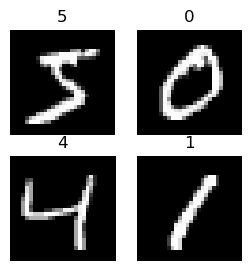

In [36]:
net.train(False)

for i in range(4):
  image, label = mnist_trainset[i]
  print(label)
  target = torch.tensor([label])
  target = nn.functional.one_hot(target, num_classes=10)
  print(target)

  lif_output = neuron.LIFNode()(image)
  print((lif_output == 0).sum())
  print(lif_output.shape)
  output = net(image)
  print(output)

figure = plt.figure(figsize=(3, 3))
cols, rows = 2, 2
for i in range(0, cols * rows):
    img, num = mnist_trainset[i]
    figure.add_subplot(rows, cols, i+1)
    plt.title(num)
    plt.axis("off")
    plt.imshow(transforms.ToPILImage(mode="L")(img), cmap="gray")
plt.show()

In [37]:
loss_fn = torch.nn.MSELoss()

x = torch.Tensor([0.5, 0.5])
y = torch.Tensor([1, 0])
loss = loss_fn(x, y)
print(loss)

tensor(0.2500)


In [38]:
def train_one_epoch(epoch_index):
  running_loss = 0.
  last_loss = 0.
  correct_count = 0
  accuracy = []

  for i, data in enumerate(train_loader):
    inputs, labels = data
    
    # convert labels to one-hot encoding able to be used by loss function
    targets = nn.functional.one_hot(labels, num_classes=10)
    targets = targets.to(torch.float32)

    optimizer.zero_grad()
    outputs = net(inputs)
    
    correct_count += (torch.argmax(outputs, dim=1) == labels).sum()

    loss = loss_fn(outputs, targets)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      running_loss = 0.

      accuracy.append(correct_count / 1000)
      correct_count = 0

  return last_loss, accuracy

In [39]:
import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
training_loss = []
validation_loss = []
training_acc = []

EPOCHS = 5

best_vloss = 1_000_000.

functional.reset_net(net)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    avg_loss, acc = train_one_epoch(epoch_number)
    training_acc += acc

    # We don't need gradients on to do reporting
    net.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = net(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    training_loss.append(avg_loss)
    validation_loss.append(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(net.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.08960563945025206
  batch 2000 loss: 0.0878067124336958
  batch 3000 loss: 0.08603598741814494
  batch 4000 loss: 0.08364571456983685
  batch 5000 loss: 0.08097107888385653
  batch 6000 loss: 0.07901675542257726
  batch 7000 loss: 0.07633885220112278
  batch 8000 loss: 0.0731433521322906
  batch 9000 loss: 0.06979087260528467
  batch 10000 loss: 0.0681491099569539
  batch 11000 loss: 0.06580357103823917
  batch 12000 loss: 0.06347670852771262
  batch 13000 loss: 0.061973272722156254
  batch 14000 loss: 0.05869892289803829
  batch 15000 loss: 0.058709535060093916
  batch 16000 loss: 0.056254045425739606
  batch 17000 loss: 0.05411523849795776
  batch 18000 loss: 0.052201491930609335
  batch 19000 loss: 0.05171021715391544
  batch 20000 loss: 0.05101576451011533
  batch 21000 loss: 0.04771366147237495
  batch 22000 loss: 0.04681268785597786
  batch 23000 loss: 0.04939376975705454
  batch 24000 loss: 0.04664305784722274
  batch 25000 loss: 0.04608053247674434

/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.0327861179505785 valid 27.28899383544922
EPOCH 2:
  batch 1000 loss: 0.03169683503362023
  batch 2000 loss: 0.03183109006820554
  batch 3000 loss: 0.0306067675076861
  batch 4000 loss: 0.033353519805671125
  batch 5000 loss: 0.03310598719613608
  batch 6000 loss: 0.030883389336271362
  batch 7000 loss: 0.03336274951056839
  batch 8000 loss: 0.032016440692878546
  batch 9000 loss: 0.033215533754838315
  batch 10000 loss: 0.03055107510842993
  batch 11000 loss: 0.03223920863148845
  batch 12000 loss: 0.03214392573356147
  batch 13000 loss: 0.029984972629458952
  batch 14000 loss: 0.03041488406442676
  batch 15000 loss: 0.029091153467371584
  batch 16000 loss: 0.03157087363176953
  batch 17000 loss: 0.031933608545137986
  batch 18000 loss: 0.030545682226714853
  batch 19000 loss: 0.02908412095610261
  batch 20000 loss: 0.02840748098255564
  batch 21000 loss: 0.03087658849434547
  batch 22000 loss: 0.02902053590569261
  batch 23000 loss: 0.03152261666594251
  batch 24000 loss:

KeyboardInterrupt: 

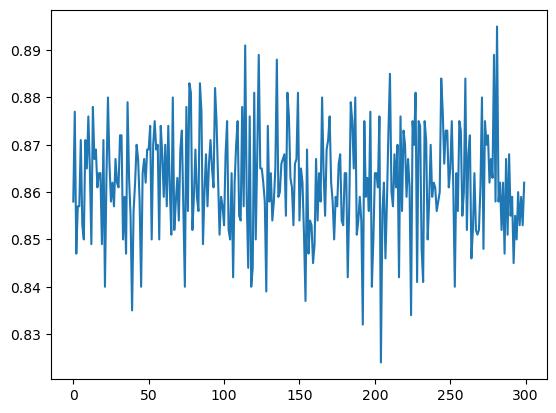

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_acc)